# Process-Bigraph: A Minimal, Hands-On Tutorial

This notebook introduces the **process-bigraph** programming model through a sequence of small, executable examples.

The goal is to explain *how computation is structured* in process-bigraph, not just how to run it. We build up from first principles:

- what a **Process** is
- what a **Step** is
- how inputs and outputs are declared as **ports**
- how updates are applied to state
- how **Composites** wire components together
- how **emitters** record simulation results

By the end, you will have a working mental model of how process-bigraph represents
time, state, and composition.

This notebook is intentionally minimal and self-contained. All examples run in-place
and are suitable as templates for larger models.

In [17]:
import sys
import inspect
import numpy as np

from process_bigraph import allocate_core
from process_bigraph.composite import Process, Step, Composite, as_process, as_step

def rebuild_core():
    top = dict(inspect.getmembers(sys.modules["__main__"]))
    return allocate_core(top=top)

core = rebuild_core()

print("✅ core created")

✅ core created


## 1. Create a Process

A **Process** is a stateful component that:
- declares its **inputs** and **outputs**
- has an `update(state, interval)` method
- may evolve state continuously over time

Below we define a simple process that moves a value toward a target.


In [18]:
class MoveToward(Process):
    """
    Move x toward target at speed 'rate' per unit time.
    (stateful Process: gets an interval argument)
    """
    config_schema = {
        "rate": {
            "_type": "float",
            "_default": 1.0,
        }
    }

    def initialize(self, config=None):
        if self.config["rate"] < 0:
            raise ValueError("MoveToward requires rate >= 0")

    def inputs(self):
        return {"x": "float", "target": "float"}

    def outputs(self):
        return {"x": "float"}

    def update(self, state, interval):
        x = float(state["x"])
        target = float(state["target"])
        rate = float(self.config["rate"])

        # bounded movement toward target
        max_step = rate * interval
        delta = np.clip(target - x, -max_step, max_step)
        return {"x": delta}

# Resolve address for the notebook-defined Process (recommended in notebooks)
MT_ADDR = f"local:!{MoveToward.__module__}.MoveToward"
print("Using MoveToward address:", MT_ADDR)

# Quick sanity check: instantiate + run once
p = MoveToward(config={"rate": 2.0}, core=core)
print("update:", p.update({"x": 0.0, "target": 10.0}, interval=1.0))  # expect x=2.0
print("✅ MoveToward Process defined")


Using MoveToward address: local:!__main__.MoveToward
update: {'x': np.float64(2.0)}
✅ MoveToward Process defined


## 2. Create a Step from a function

A **Step** is a **non-temporal** update rule:
- it has inputs and outputs (ports), just like a Process
- it runs **without a time interval** (`interval` is not passed)
- it is scheduled like a **workflow/rule** inside a Composite

In this tutorial we build a Step from a *pure function* for simplicity, but a Step can also be implemented as a `Step` subclass (and could carry internal state if needed).

Steps are useful for *instantaneous* or *algebraic* computations (e.g., derived variables, guards, routing logic, bookkeeping).

In [19]:
@as_step(
    inputs={"a": "float", "b": "float"},
    outputs={"sum": "overwrite[float]"},
)
def update_add(state):
    return {"sum": float(state["a"]) + float(state["b"])}

# Quick sanity check: create the Step and run it once
s = update_add(config={}, core=core)
print("step update:", s.update({"a": 3.0, "b": 4.0}))  # expect {'sum': 7.0}

# Confirm it registered in the Core
print("core.access('add') ->", core.access("add"))
print("✅ Step created + registered as 'add'")


step update: {'sum': 7.0}
core.access('add') -> add
✅ Step created + registered as 'add'


## 3. Inspect ports with `interface()`

Every Process and Step exposes its ports through `interface()`.

This tells us:
- which parts of the state the component **reads** (inputs)
- which parts of the state it **writes** (outputs)

Ports are described using schemas.


In [20]:
# Inspect ports for the Process
proc = MoveToward(config={"rate": 1.0}, core=core)
proc_iface = proc.interface()

print("Process inputs schema:")
print(core.render(proc_iface["inputs"]))

print("\nProcess outputs schema:")
print(core.render(proc_iface["outputs"]))


# Inspect ports for the Step
step = update_add(config={}, core=core)
step_iface = step.interface()

print("\nStep inputs schema:")
print(core.render(step_iface["inputs"]))

print("\nStep outputs schema:")
print(core.render(step_iface["outputs"]))

print("✅ Ports inspected via interface()")


Process inputs schema:
x:float|target:float

Process outputs schema:
x:float

Step inputs schema:
a:float|b:float

Step outputs schema:
sum:overwrite[float]
✅ Ports inspected via interface()


## 4. Run a single update

Calling `update(...)` returns a **partial update** (a patch), not a full state.

The Core:
- fills missing defaults
- applies updates according to the output schema
- ensures schema-aware merging

This is the low-level mechanism that `Composite` automates.


In [21]:
# Instantiate the process
proc = MoveToward(config={"rate": 2.0}, core=core)

# Inspect interface
iface = proc.interface()

# Initial input state (what the process reads)
input_state = {"x": 0.0, "target": 10.0}
dt = 1.0

# 1) Run the process update
update = proc.update(input_state, dt)
print("raw update:", update)

# 2) Prepare a full state consistent with the schema
state = core.fill(iface["inputs"], {})
state = core.fill(iface["outputs"], state)
state.update(input_state)

print("filled state before apply:", state)

# 3) Apply the update using the output schema
new_state, merges = core.apply(
    iface["outputs"],
    state,
    update
)

print("new state after apply:", new_state)
print("merges:", merges)

print("✅ Single update applied via Core")

raw update: {'x': np.float64(2.0)}
filled state before apply: {'x': 0.0, 'target': 10.0}
new state after apply: {'x': np.float64(2.0), 'target': 10.0}
merges: []
✅ Single update applied via Core


## 5. Run a simulation with a Composite

A **Composite** wires Processes and Steps together and manages:
- input/output wiring
- update scheduling
- state updates over time

This lets us run simulations declaratively, without manually calling `update()`.


In [22]:
# Initial conditions
initial_x = 0.0
target_x = 10.0

print("Initial x:", initial_x)
print("Target x:", target_x)

# Define a composite with one process and shared state
composite = Composite(
    {
        "state": {
            # shared state
            "x": initial_x,
            "target": target_x,

            # process specification
            "move": {
                "_type": "process",
                "address": MT_ADDR,
                "config": {"rate": 2.0},
                "interval": 1.0,
                "inputs": {
                    "x": ["x"],
                    "target": ["target"],
                },
                "outputs": {
                    "x": ["x"],  # delta merged
                },
            },
        }
    },
    core=core,
)

# Run the simulation for 5 time units
composite.run(10.0)

# Inspect results
final_x = composite.state["x"]

print("Final x:", final_x)
print("✅ Composite simulation ran")


Initial x: 0.0
Target x: 10.0
Final x: 10.0
✅ Composite simulation ran


## 6. Compose multiple Processes and Steps

Composites allow us to build workflows by wiring together:
- **Steps** for instantaneous transformations
- **Processes** for time-dependent dynamics

Each component reads from and writes to a shared state tree.


In [23]:
# ---- Steps for the workflow ----
@as_step(
    inputs={"t": "float"},
    outputs={"target": "overwrite[float]"},
)
def update_sine_target(state):
    """
    target(t) = center + amplitude * sin(omega * t)
    """
    t = float(state["t"])
    center = 5.0
    amplitude = 5.0
    period = 8.0
    omega = 2.0 * np.pi / period
    return {"target": center + amplitude * np.sin(omega * t)}

@as_step(
    inputs={"x": "float", "target": "float"},
    outputs={"error": "overwrite[float]"},
)
def update_error(state):
    return {"error": float(state["target"]) - float(state["x"])}


# ---- Initial conditions ----
initial_env = {
    "t": 0.0,
    "x": 0.0,
    "target": 0.0,
    "error": 0.0,
}

print("\nBefore run:")
for k in ["t", "x", "target", "error"]:
    print(f"  {k}: {initial_env[k]}")

workflow = Composite(
    {
        "state": {
            "Env": dict(initial_env),

            # Step 1: compute a time-varying target from time
            "targeter": {
                "_type": "step",
                "address": "local:sine_target",
                "inputs": {"t": ["global_time"]},
                "outputs": {"target": ["Env", "target"]},
            },

            # Process: move x toward the current target
            "mover": {
                "_type": "process",
                "address": MT_ADDR,
                "config": {"rate": 1.0},
                "interval": 0.1,
                "inputs": {
                    "x": ["Env", "x"],
                    "target": ["Env", "target"],
                },
                "outputs": {"x": ["Env", "x"]},
            },

            # Step 2: compute an observable error signal (target - x)
            "observer": {
                "_type": "step",
                "address": "local:error",
                "inputs": {
                    "x": ["Env", "x"],
                    "target": ["Env", "target"],
                },
                "outputs": {"error": ["Env", "error"]},
            },
        }
    },
    core=core,
)


workflow.run(10.0)

final_env = workflow.state["Env"]
print("\nAfter run:")
for k in ["t", "x", "target", "error"]:
    print(f"  {k}: {final_env.get(k)}")

print("✅ Multi-component workflow ran")



Before run:
  t: 0.0
  x: 0.0
  target: 0.0
  error: 0.0

After run:
  t: 0.0
  x: 4.364466094067238
  target: 10.0
  error: 5.635533905932762
✅ Multi-component workflow ran


## 7. Add an emitter (record results over time)

An **emitter** records selected parts of the state at each simulation tick.
We specify what to record by wiring state paths into the emitter.
After running, we query the emitter for a time series of recorded values.


In [24]:
from process_bigraph.emitter import emitter_from_wires

# Build a composite like before, but add an emitter that records time + Env variables
workflow_with_emitter = Composite(
    {
        "state": {
            "Env": {
                "t": 0.0,
                "x": 0.0,
                "target": 0.0,
                "error": 0.0,
            },
            # Step: compute moving target from Env.t
            "targeter": {
                "_type": "step",
                "address": "local:sine_target",
                "inputs": {"t": ["global_time"]},
                "outputs": {"target": ["Env", "target"]},
            },

            # Process: move x toward the (changing) target
            "mover": {
                "_type": "process",
                "address": MT_ADDR,
                "config": {"rate": 1.0},
                "interval": 1,
                "inputs": {
                    "x": ["Env", "x"],
                    "target": ["Env", "target"],
                },
                "outputs": {
                    "x": ["Env", "x"],
                },
            },

            # Step: compute error after mover updates x
            "observer": {
                "_type": "step",
                "address": "local:error",
                "inputs": {
                    "x": ["Env", "x"],
                    "target": ["Env", "target"],
                },
                "outputs": {
                    "error": ["Env", "error"],
                },
            },

            # Emitter: record specified wires each tick
            "emitter": emitter_from_wires(
                {
                    "time": ["global_time"],
                    "t": ["Env", "t"],
                    "x": ["Env", "x"],
                    "target": ["Env", "target"],
                    "error": ["Env", "error"],
                }
            ),
        }
    },
    core=core,
)

# Run and then read back recorded rows
workflow_with_emitter.run(10.0)

records = workflow_with_emitter.state["emitter"]["instance"].query()
print("n records:", len(records))
print("first record:", records[0])
print("last record:", records[-1])

records  # in notebooks, this will display nicely


n records: 11
first record: {'time': 0.0, 't': 0.0, 'x': 0.0, 'target': 5.0, 'error': 5.0}
last record: {'time': 10.0, 't': 0.0, 'x': 4.0, 'target': 10.0, 'error': 6.0}


[{'time': 0.0, 't': 0.0, 'x': 0.0, 'target': 5.0, 'error': 5.0},
 {'time': 1.0,
  't': 0.0,
  'x': 1.0,
  'target': 8.535533905932738,
  'error': 7.535533905932738},
 {'time': 2.0, 't': 0.0, 'x': 2.0, 'target': 10.0, 'error': 8.0},
 {'time': 3.0,
  't': 0.0,
  'x': 3.0,
  'target': 8.535533905932738,
  'error': 5.535533905932738},
 {'time': 4.0,
  't': 0.0,
  'x': 4.0,
  'target': 5.000000000000001,
  'error': 1.0000000000000009},
 {'time': 5.0,
  't': 0.0,
  'x': 5.0,
  'target': 1.4644660940672627,
  'error': -3.5355339059327373},
 {'time': 6.0, 't': 0.0, 'x': 4.0, 'target': 0.0, 'error': -4.0},
 {'time': 7.0,
  't': 0.0,
  'x': 3.0,
  'target': 1.4644660940672614,
  'error': -1.5355339059327386},
 {'time': 8.0,
  't': 0.0,
  'x': 2.0,
  'target': 4.999999999999999,
  'error': 2.999999999999999},
 {'time': 9.0,
  't': 0.0,
  'x': 3.0,
  'target': 8.535533905932738,
  'error': 5.535533905932738},
 {'time': 10.0, 't': 0.0, 'x': 4.0, 'target': 10.0, 'error': 6.0}]

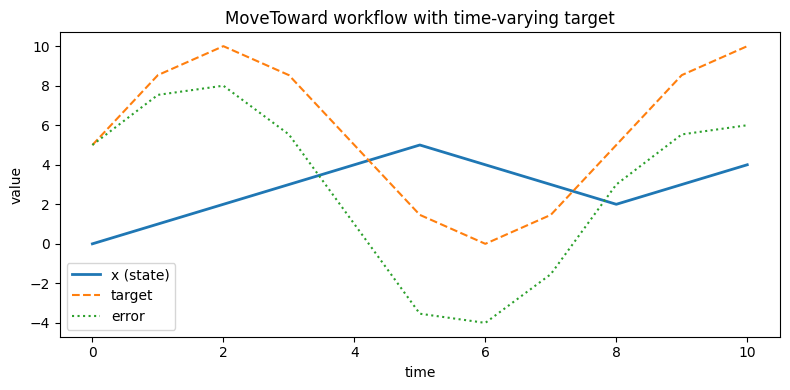

In [25]:
import matplotlib.pyplot as plt

# Convert records (list of dicts) to columns
times = [r["time"] for r in records]
x_vals = [r["x"] for r in records]
target_vals = [r["target"] for r in records]
error_vals = [r["error"] for r in records]

plt.figure(figsize=(8, 4))

plt.plot(times, x_vals, label="x (state)", linewidth=2)
plt.plot(times, target_vals, label="target", linestyle="--")
plt.plot(times, error_vals, label="error", linestyle=":")

plt.xlabel("time")
plt.ylabel("value")
plt.title("MoveToward workflow with time-varying target")
plt.legend()
plt.tight_layout()
plt.show()